# CIFAR-10: Best-Practice CNN + SVM Comparison + PCA Visualization

This notebook keeps the **same main purpose** as your original code, but fixes dataset splitting, missing imports, and upgrades the model + training pipeline:

- Train a strong **CNN with augmentation** on CIFAR-10  
- Evaluate on the **official test set**  
- Plot training curves, print classification report, and show confusion matrix  
- Train an **SVM baseline** (best practice: SVM on **CNN features**)  
- 3D **PCA visualization** (on CNN features)  
- Compare **original vs augmented** image  
- Predict on an **external image** (fixed preprocessing)


In [30]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
#pip install -U "tensorflow>=2.9"


In [32]:
# Imports + Reproducibility
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from tensorflow.keras.datasets import cifar10

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA

# Optional (nice 3D plot). If not available, we'll fallback to matplotlib 3D.
try:
    import plotly.express as px
    PLOTLY_AVAILABLE = True
except Exception:
    PLOTLY_AVAILABLE = False

# Reproducibility (best effort)
tf.keras.utils.set_random_seed(42)
np.random.seed(42)

print("TensorFlow:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)


TensorFlow: 2.20.0
GPU available: True



Official CIFAR-10 split:
Train: (50000, 32, 32, 3) (50000,)
Test : (10000, 32, 32, 3) (10000,)

After train/val split:
Train: (40000, 32, 32, 3) (40000,)
Val  : (10000, 32, 32, 3) (10000,)
Test : (10000, 32, 32, 3) (10000,)


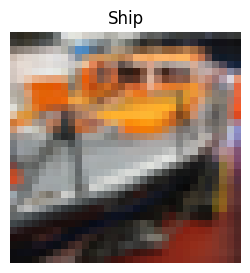

In [33]:
# =========================
# Load CIFAR-10 properly
# =========================
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
num_classes = 10

y_train_full = y_train_full.reshape(-1,)
y_test = y_test.reshape(-1,)

print("\nOfficial CIFAR-10 split:")
print("Train:", X_train_full.shape, y_train_full.shape)
print("Test :", X_test.shape, y_test.shape)

# Create a VALIDATION set from the official training set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

# Normalize
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

print("\nAfter train/val split:")
print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

# =========================
# Utility: plot sample
# =========================
def plot_sample(X, y, index):
    plt.figure(figsize=(3,3))
    plt.imshow(X[index])
    plt.title(classes[int(y[index])])
    plt.axis('off')
    plt.show()

plot_sample(X_train, y_train, 56)


In [34]:
# =========================
# tf.data pipelines (fast)
# =========================
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE


train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(20000, seed=42, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# =========================
# Data Augmentation (inside model)
# =========================
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)


In [35]:
# =========================
# Better CNN: small ResNet-style (strong for CIFAR-10)
# =========================
weight_decay = 1e-4
l2 = regularizers.l2(weight_decay)

def conv_bn_lrelu(x, filters, k=3, s=1):
    x = layers.Conv2D(filters, k, strides=s, padding="same",
                      use_bias=False, kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)
    return x

def residual_block(x, filters, downsample=False):
    stride = 2 if downsample else 1
    shortcut = x

    x = conv_bn_lrelu(x, filters, k=3, s=stride)
    x = layers.Conv2D(filters, 3, strides=1, padding="same",
                      use_bias=False, kernel_regularizer=l2)(x)
    x = layers.BatchNormalization()(x)

    # Match dimensions for residual add
    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same",
                                 use_bias=False, kernel_regularizer=l2)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.LeakyReLU(0.1)(x)
    return x

inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)

# Stem
x = conv_bn_lrelu(x, 32)
x = conv_bn_lrelu(x, 32)

# Stages
x = residual_block(x, 32)
x = residual_block(x, 32)

x = residual_block(x, 64, downsample=True)
x = residual_block(x, 64)

x = residual_block(x, 128, downsample=True)
x = residual_block(x, 128)

x = residual_block(x, 256, downsample=True)
x = residual_block(x, 256)

x = layers.GlobalAveragePooling2D(name="features")(x)
x = layers.Dropout(0.3)(x)
logits = layers.Dense(num_classes, name="logits")(x)

model = keras.Model(inputs, logits, name="CIFAR10_ResNetSmall")

# --- put this here (after train_ds exists, before model.compile) ---
EPOCHS = 10

steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()

lr = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1,
    decay_steps=steps_per_epoch * EPOCHS
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
# ---------------------------------------------------------------


loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])


model.summary()


Model: "CIFAR10_ResNetSmall"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 32, 32, 3) │          0 │ input_layer_11[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_147 (Conv2D) │ (None, 32, 32,    │        864 │ data_augmentatio… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_147[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_126     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_148 (Conv2D) │ (None, 32, 32,    │      9,216 │ leaky_re_lu_126[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_148[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_127     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_149 (Conv2D) │ (None, 32, 32,    │      9,216 │ leaky_re_lu_127[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_149[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_128     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_150 (Conv2D) │ (None, 32, 32,    │      9,216 │ leaky_re_lu_128[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_150[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_56 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ leaky_re_lu_127[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_129     │ (None, 32, 32,    │          0 │ add_56[0][0]      │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_151 (Conv2D) │ (None, 32, 32,    │      9,216 │ leaky_re_lu_129[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_151[0][0]

 Total params: 2,811,754 (10.73 MB)

 Trainable params: 2,806,890 (10.71 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [36]:
# =========================
# Callbacks (make training "best")
# =========================
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_cifar10_model.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
]




history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/10
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2642 - loss: 2.5456
Epoch 1: val_accuracy improved from -inf to 0.23330, saving model to best_cifar10_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 86ms/step - accuracy: 0.2646 - loss: 2.5433 - val_accuracy: 0.2333 - val_loss: 2.9078
Epoch 2/10
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4355 - loss: 1.8114
Epoch 2: val_accuracy improved from 0.23330 to 0.38400, saving model to best_cifar10_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.4356 - loss: 1.8110 - val_accuracy: 0.3840 - val_loss: 2.1185
Epoch 3/10
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5300 - loss: 1.5598
Epoch 3: val_accuracy improved from 0.38400 to 0.55340, saving model to best_cifar10_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.5301 - loss: 1.5595 - val_accuracy: 0.5534 - val_loss: 1.5200
Epoch 4/10
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6022 - loss: 1.3829
Epoch 4


Official TEST accuracy: 0.7631000280380249


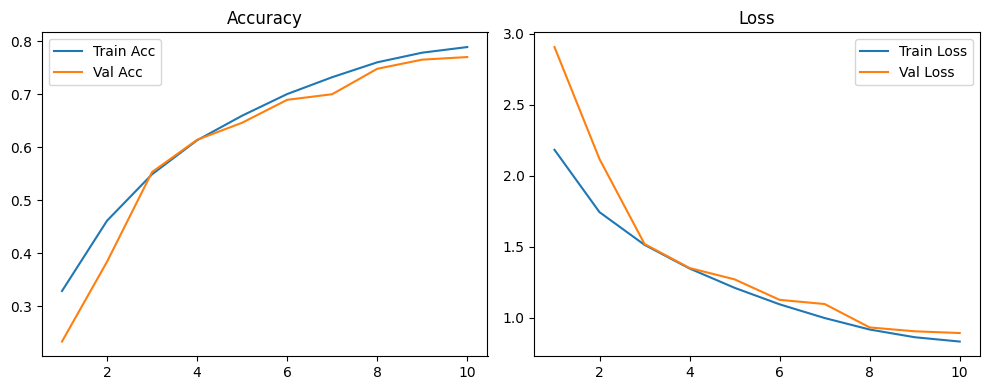

In [37]:
# =========================
# Evaluate on official TEST set
# =========================
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print("\nOfficial TEST accuracy:", test_acc)

# =========================
# Training curves (train + val)
# =========================
hist = history.history
epochs_r = range(1, len(hist["accuracy"]) + 1)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_r, hist["accuracy"], label="Train Acc")
plt.plot(epochs_r, hist["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_r, hist["loss"], label="Train Loss")
plt.plot(epochs_r, hist["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()



Classification Report (TEST):
              precision    recall  f1-score   support

    Airplane       0.74      0.86      0.80      1000
  Automobile       0.84      0.93      0.88      1000
        Bird       0.81      0.56      0.66      1000
         Cat       0.68      0.49      0.57      1000
        Deer       0.78      0.67      0.72      1000
         Dog       0.78      0.58      0.66      1000
        Frog       0.62      0.92      0.74      1000
       Horse       0.77      0.85      0.81      1000
        Ship       0.89      0.87      0.88      1000
       Truck       0.78      0.90      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



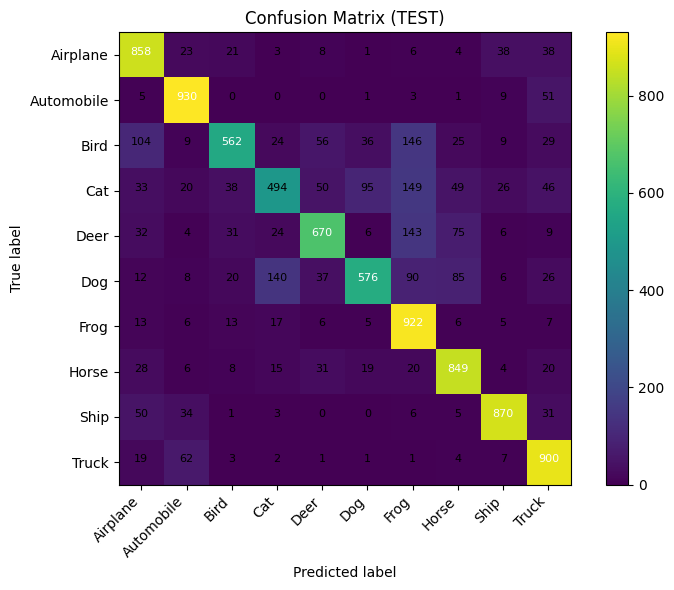

In [38]:
# =========================
# Classification report + confusion matrix (TEST)
# =========================
y_pred_logits = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_pred_logits, axis=1)

print("\nClassification Report (TEST):")
print(classification_report(y_test, y_pred, target_names=classes))

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8,6))
    plt.imshow(cm)
    plt.title("Confusion Matrix (TEST)")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() * 0.6
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=8)

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes)


In [39]:
# =========================
# SVM baseline (BEST way): SVM on CNN features
# =========================
feature_extractor = keras.Model(model.input, model.get_layer("features").output)

train_ds_noshuf = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .batch(BATCH_SIZE).prefetch(AUTOTUNE)


# Extract features in batches for speed
train_features = feature_extractor.predict(train_ds_noshuf, verbose=0)
val_features   = feature_extractor.predict(val_ds, verbose=0)
test_features  = feature_extractor.predict(test_ds, verbose=0)


train_features = train_features.reshape(train_features.shape[0], -1)
val_features   = val_features.reshape(val_features.shape[0], -1)
test_features  = test_features.reshape(test_features.shape[0], -1)

# Train SVM on (train + val) features for a fair final comparison
X_svm_train = np.concatenate([train_features, val_features], axis=0)
y_svm_train = np.concatenate([y_train, y_val], axis=0)

svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(dual=False, max_iter=5000))
])

param_grid = {
    "svm__C": [0.1, 1, 3, 10]
}

# Tune on TRAIN only
grid = GridSearchCV(svm_pipe, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(train_features, y_train)

print("\nBest SVM params:", grid.best_params_)

# Refit on TRAIN+VAL using best C
best_C = grid.best_params_["svm__C"]
svm_best = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(C=best_C, dual=False, max_iter=5000))
])
svm_best.fit(X_svm_train, y_svm_train)

svm_test_acc = svm_best.score(test_features, y_test)
print("SVM TEST accuracy (on CNN features):", svm_test_acc)



Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best SVM params: {'svm__C': 0.1}
SVM TEST accuracy (on CNN features): 0.8007


In [40]:
# =========================
# 3D Visualization (PCA on CNN features)
# =========================
# Use a subset so plotting is fast
N = 6000
idx = np.random.RandomState(42).choice(len(X_svm_train), size=min(N, len(X_svm_train)), replace=False)
feat_subset = X_svm_train[idx]
y_subset = y_svm_train[idx]

pca = PCA(n_components=3, random_state=42)
feat_3d = pca.fit_transform(feat_subset)

if PLOTLY_AVAILABLE:
    fig = px.scatter_3d(
        x=feat_3d[:,0], y=feat_3d[:,1], z=feat_3d[:,2],
        color=y_subset.astype(str),
        title="3D PCA of CNN Features (CIFAR-10)",
        labels={"color": "Class"}
    )
    fig.show()
else:
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(feat_3d[:,0], feat_3d[:,1], feat_3d[:,2], c=y_subset, s=5)
    ax.set_title("3D PCA of CNN Features (CIFAR-10)")
    plt.show()


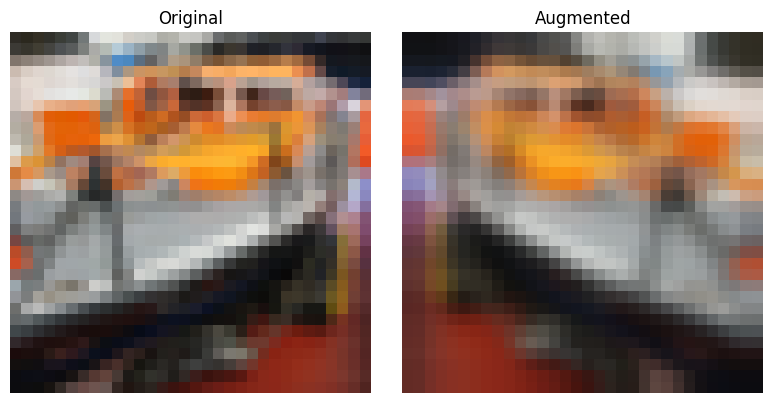

In [41]:
# =========================
# Compare original vs augmented image
# =========================
index = 56
original_image = X_train[index]
augmented_image = data_augmentation(tf.expand_dims(original_image, 0), training=True)[0].numpy()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(augmented_image)
plt.title("Augmented")
plt.axis("off")

plt.tight_layout()
plt.show()



External image prediction: Automobile (99.03%)


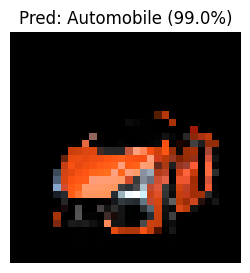

In [42]:
# =========================
# Predict on external image (fixed preprocessing)
# =========================
random_url = "https://www.lamborghini.com/sites/it-en/files/DAM/lamborghini/facelift_2019/homepage/families-gallery/2023/revuelto/revuelto_m.png"

local_path = tf.keras.utils.get_file("external_img.png", origin=random_url)
img = keras.utils.load_img(local_path, target_size=(32, 32))
img_array = keras.utils.img_to_array(img).astype("float32") / 255.0
img_array = tf.expand_dims(img_array, 0)

pred = model.predict(img_array, verbose=0)
probs = tf.nn.softmax(pred[0]).numpy()

top = np.argmax(probs)
print(f"\nExternal image prediction: {classes[top]} ({probs[top]*100:.2f}%)")

plt.figure(figsize=(3,3))
plt.imshow(img)
plt.title(f"Pred: {classes[top]} ({probs[top]*100:.1f}%)")
plt.axis("off")
plt.show()
